In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import string
import h5py
import matplotlib
from collections import Counter
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


pixel_depth = 255.0  # Number of levels per pixel.
screen_width = 800
screen_height = 600

In [6]:
def get_attr(c, i, attr):
    d = c[c['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    if d.dtype == 'float64':
        return d.reshape(-1)
    return np.array([c[x].value for x in d]).squeeze()

def get_label(c, i):
    d = c[c['digitStruct']['name'][i][0]].value.tostring()
    return d.replace('\x00', '')

def load_data(path):
    c = h5py.File(path)
    images = a = np.ndarray(shape=(c['digitStruct']['name'].shape[0], ), dtype='|S15')
    labels = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    labels.fill(10)
    tops = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    heights = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    widths = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    lefts = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    for i in xrange(c['digitStruct']['name'].shape[0]):
        images[i] = get_label(c, i)
        l = get_attr(c, i, 'label')
        t = get_attr(c, i, 'top')
        h = get_attr(c, i, 'height')
        w = get_attr(c, i, 'width')
        le = get_attr(c, i, 'left')
        
        labels[i, :l.shape[0]] = l
        tops[i, :t.shape[0]] = t
        heights[i, :h.shape[0]] = h
        widths[i, :w.shape[0]] = w
        lefts[i, :le.shape[0]] = le
    
        if (i % 5000 == 0):
            print(i, "elapsed")
    
    return labels, images, tops, heights, widths, lefts

In [7]:
train__tuple = load_data('train/digitStruct.mat')
test__tuple = load_data('test/digitStruct.mat')
extra__tuple = load_data('extra/digitStruct.mat')

0 elapsed
5000 elapsed
10000 elapsed
15000 elapsed
20000 elapsed
25000 elapsed
30000 elapsed
0 elapsed
5000 elapsed
10000 elapsed
0 elapsed
5000 elapsed
10000 elapsed
15000 elapsed
20000 elapsed
25000 elapsed
30000 elapsed
35000 elapsed
40000 elapsed
45000 elapsed
50000 elapsed
55000 elapsed
60000 elapsed
65000 elapsed
70000 elapsed
75000 elapsed
80000 elapsed
85000 elapsed
90000 elapsed
95000 elapsed
100000 elapsed
105000 elapsed
110000 elapsed
115000 elapsed
120000 elapsed
125000 elapsed
130000 elapsed
135000 elapsed
140000 elapsed
145000 elapsed
150000 elapsed
155000 elapsed
160000 elapsed
165000 elapsed
170000 elapsed
175000 elapsed
180000 elapsed
185000 elapsed
190000 elapsed
195000 elapsed
200000 elapsed


In [13]:
def maybe_pickle(struct, force=False):
    if os.path.exists(struct + '.pickle') and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % struct)
    else:
      print('Pickling %s.' % struct + '.pickle')
      permutation = np.random.permutation(extra__tuple[1].shape[0])[:2000]
      dataset = {
            'train': {
                'labels': train__tuple[0],
                'images': train__tuple[1],  
                'tops': train__tuple[2],
                'heights': train__tuple[3],
                'widths': train__tuple[4],
                'lefts': train__tuple[5],
                
                
            }, 
            'test': {
                'labels': test__tuple[0],
                'images': test__tuple[1],  
                'tops': test__tuple[2],
                'heights': test__tuple[3],
                'widths': test__tuple[4],
                'lefts': test__tuple[5],
            },
            'extra': {
                'labels': extra__tuple[0],
                'images': extra__tuple[1],  
                'tops': extra__tuple[2],
                'heights': extra__tuple[3],
                'widths': extra__tuple[4],
                'lefts': extra__tuple[5],
            },
            'valid': {
                'labels': extra__tuple[0][permutation],
                'images': extra__tuple[1][permutation],  
                'tops': extra__tuple[2][permutation],
                'heights': extra__tuple[3][permutation],
                'widths': extra__tuple[4][permutation],
                'lefts': extra__tuple[5][permutation],
            }
      }
      try:
        with open( struct + '.pickle', 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to',  struct + '.pickle', ':', e)
  
    return  struct + '.pickle'

In [12]:
extra__tuple[0][[1,2,3,4]].shape

(4, 6)

In [14]:
maybe_pickle('svhn')

Pickling svhn..pickle


'svhn.pickle'

In [15]:
with open('svhn.pickle', 'rb') as f:
        dataset = pickle.load(f)

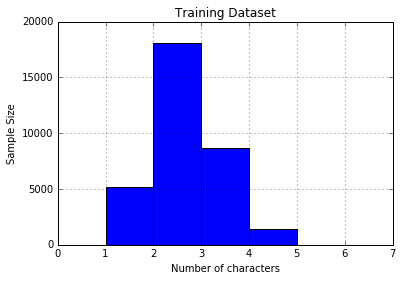

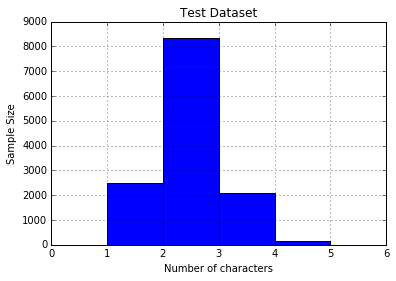

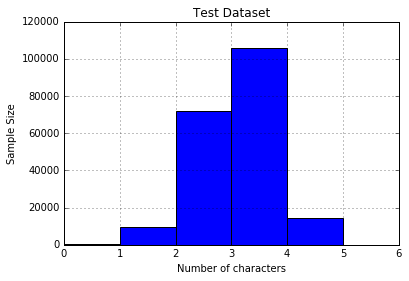

In [17]:
c = Counter(np.sum(dataset["train"]["tops"] > 0, axis =1))
l = plt.bar(c.keys(), c.values(), 1, color="blue")

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Training Dataset')

plt.show()

c = Counter(np.sum(dataset["test"]["tops"] > 0, axis =1))
l = plt.bar(c.keys(), c.values(), 1, color="blue")

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Test Dataset')

plt.show()

c = Counter(np.sum(dataset["extra"]["tops"] > 0, axis =1))
l = plt.bar(c.keys(), c.values(), 1, color="blue")

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Test Dataset')

plt.show()

In [13]:
np.std(np.max(dataset["test"]["heights"], axis=1)), np.mean(np.max(dataset["test"]["heights"], axis=1)), \
np.median(np.max(dataset["test"]["heights"], axis=1))

(13.45875541177187, 27.898607284970922, 24.0)

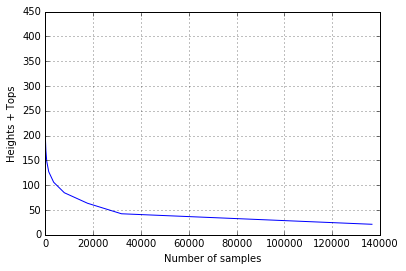

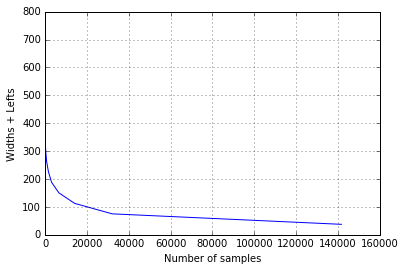

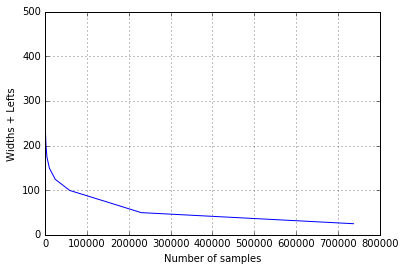

In [18]:
hist = np.histogram(dataset["train"]["heights"] +dataset["train"]["tops"], bins=20)
y = hist[1][1:]
l = plt.plot(hist[0][:], y, linewidth=1)

plt.xlabel('Number of samples')
plt.ylabel('Heights + Tops')
plt.grid(True)

plt.show()

hist = np.histogram(dataset["train"]["widths"] +dataset["train"]["lefts"], bins=20)
y = hist[1][1:]
l = plt.plot(hist[0][:], y, linewidth=1)

plt.xlabel('Number of samples')
plt.ylabel('Widths + Lefts')
plt.grid(True)

plt.show()

hist = np.histogram(dataset["extra"]["widths"] +dataset["extra"]["lefts"], bins=20)
y = hist[1][1:]
l = plt.plot(hist[0][:], y, linewidth=1)

plt.xlabel('Number of samples')
plt.ylabel('Widths + Lefts')
plt.grid(True)

plt.show()